In [ ]:
import os
import datetime
import numpy as np
import pandas as pd

import omegaconf

import torch
import torch.nn as nn
from pytorch_lightning import Trainer

from AmbiSplice import visuals
from AmbiSplice import utils

import importlib
import run as run
importlib.reload(run.models)
importlib.reload(run.datasets)
importlib.reload(run.litrun_module)
importlib.reload(run.litrun_module.loss_metrics)
importlib.reload(run)

/home/xqiu/anaconda3/envs/ambisplice/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/xqiu/anaconda3/envs/ambisplice/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened

<module 'run_ambisplice' from '/home/xqiu/bench/AmbiSplice/run_ambisplice.py'>

## Evaluate a model from a checkpoint

In [ ]:
import os
ckpt_dir = 'checkpoints/PangolinSingle_Pangolin_2025-10-18_12-41-38_btn1jd24'
ckpt_dir = 'checkpoints/pangolin.pangolin_2025-10-21_22-16-17_mnsgbck4'

ckpt_path = os.path.join(ckpt_dir, 'last.ckpt')
if not os.path.exists(ckpt_path):
    ckpt_files = [os.path.join(ckpt_dir, f) for f in os.listdir(ckpt_dir) if f.endswith('.ckpt')]
    ckpt_path = max(ckpt_files, key=os.path.getmtime)
print(f"Using checkpoint: {ckpt_path}")

if os.path.exists(os.path.join(ckpt_dir, 'train.yaml')):
    cfg_path = os.path.join(ckpt_dir, 'train.yaml')
else:
    cfg_path = os.path.join(os.getcwd(), 'configs', 'train.yaml')

main_cfg = omegaconf.OmegaConf.load(cfg_path)
omegaconf.OmegaConf.set_struct(main_cfg, False)  # allow new attribute assignment
main_cfg.stage = 'evaluate'

accelerator, devices = run.get_accelerator_devices(gpus=main_cfg.gpus)

main_cfg.model.type = 'Pangolin'
torch_model = run.get_torch_model(main_cfg.model)

main_cfg.dataset.type = 'Pangolin'
main_cfg.dataset.train_path = None # 'data/pangolin/dataset_train_all.h5'
main_cfg.dataset.predict_path = 'data/pangolin/dataset_test_1.h5'
main_cfg.dataset.predict_size = 20000
datasets = run.get_datasets(main_cfg.dataset)

litdata = run.get_litdata(datasets, main_cfg.dataloader)

# main_cfg.litrun.resume_from_ckpt = os.path.join(
    # os.getcwd(), "checkpoints/PangolinSingle_2025-10-01_22-00-46_enonuk23/epoch=016-step=008500.ckpt")

main_cfg.litrun.resume_from_ckpt = ckpt_path    
litrun = run.get_litrun(main_cfg.litrun, torch_model)

INFO:run_ambisplice:Initialized model Pangolin with config:
debug: ${debug}
type: Pangolin
dropout: 0.1
loss: cls+psi
loss_scale_cls: 0.5
loss_scale_psi: 0.5
state_dict_path: null



Using checkpoint: checkpoints/pangolin.pangolin_2025-10-21_22-16-17_mnsgbck4/last.ckpt
Available accelerator: cuda; devices: [0]


INFO:run_ambisplice:Initialized datasets with config:
debug: ${debug}
stage: ${stage}
type: Pangolin
train_path: null
val_path: null
test_path: null
predict_path: data/pangolin/dataset_test_1.h5
split_seed: 111
train_size: null
val_size: null
test_size: null
predict_size: 20000
enable_cache: false
tissue_types:
- heart
- liver
- brain
- testis

INFO:run_ambisplice:Initialized litdata with config:
debug: ${debug}
train_batch_size: 96
val_batch_size: 128
test_batch_size: 128
predict_batch_size: 128
train_shuffle: true
val_shuffle: false
test_shuffle: false
predict_shuffle: false
num_workers: 4
prefetch_factor: 7

INFO:run_ambisplice:Initialized litrun with config:
debug: ${debug}
seed: 123
resume_from_ckpt: checkpoints/pangolin.pangolin_2025-10-21_22-16-17_mnsgbck4/last.ckpt
resume_model_weights_only: true
optimizer:
  learning_rate: 0.0007
  eps: 1.0e-08
  lr_scheduler: CosineAnnealingWarmRestarts
  lr_interval: epoch
  lr_T_0: 3
  lr_T_mult: 2
  last_lr_step: -1
trainer:
  min_epochs: 

In [3]:
# trainer = lit_run.fit(lit_data, accelerator=accelerator, devices=devices, save_cfg=main_cfg)

In [4]:
import yaml
import torch
save_prefix = os.path.join(ckpt_dir, "pangolin_test")
if os.path.exists(f"{save_prefix}_sum_metrics.yaml"):
    eval_feats, eval_preds = torch.load(f"{save_prefix}_eval_outputs.pt")
    with open(f"{save_prefix}_sum_metrics.yaml", 'r') as f:
        sum_metrics = yaml.safe_load(f)
    # ind_metrics = pd.read_csv(f"{save_prefix}_ind_metrics.csv")
else:
    eval_outputs = litrun.evaluate(datamodule=litdata, save_prefix=save_prefix)
    eval_feats = eval_outputs['feats']
    eval_preds = eval_outputs['preds']
    sum_metrics = eval_outputs['sum_metrics']
    ind_metrics = eval_outputs['ind_metrics']

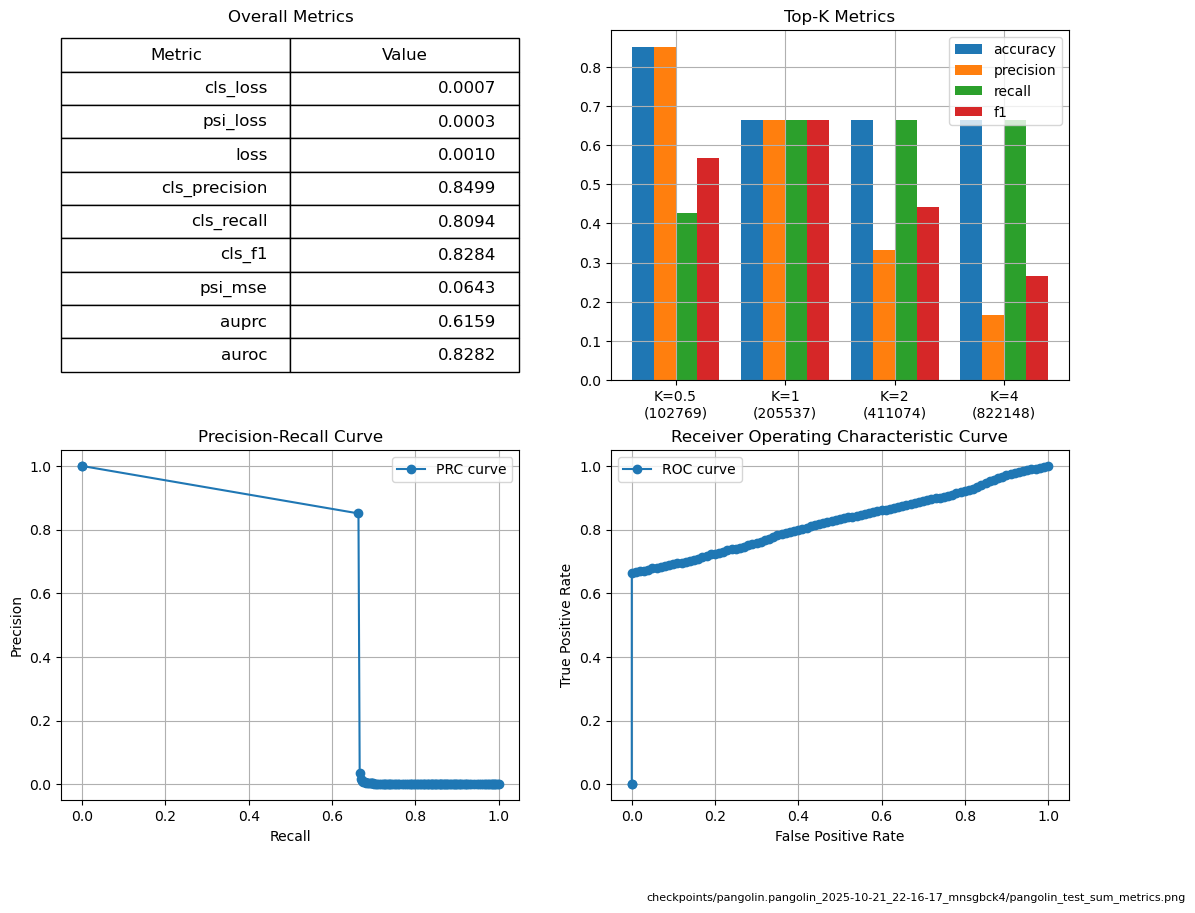

In [9]:
importlib.reload(visuals)
visuals.plot_sum_metrics(sum_metrics, save_prefix=f'{save_prefix}_sum_metrics', display=False)

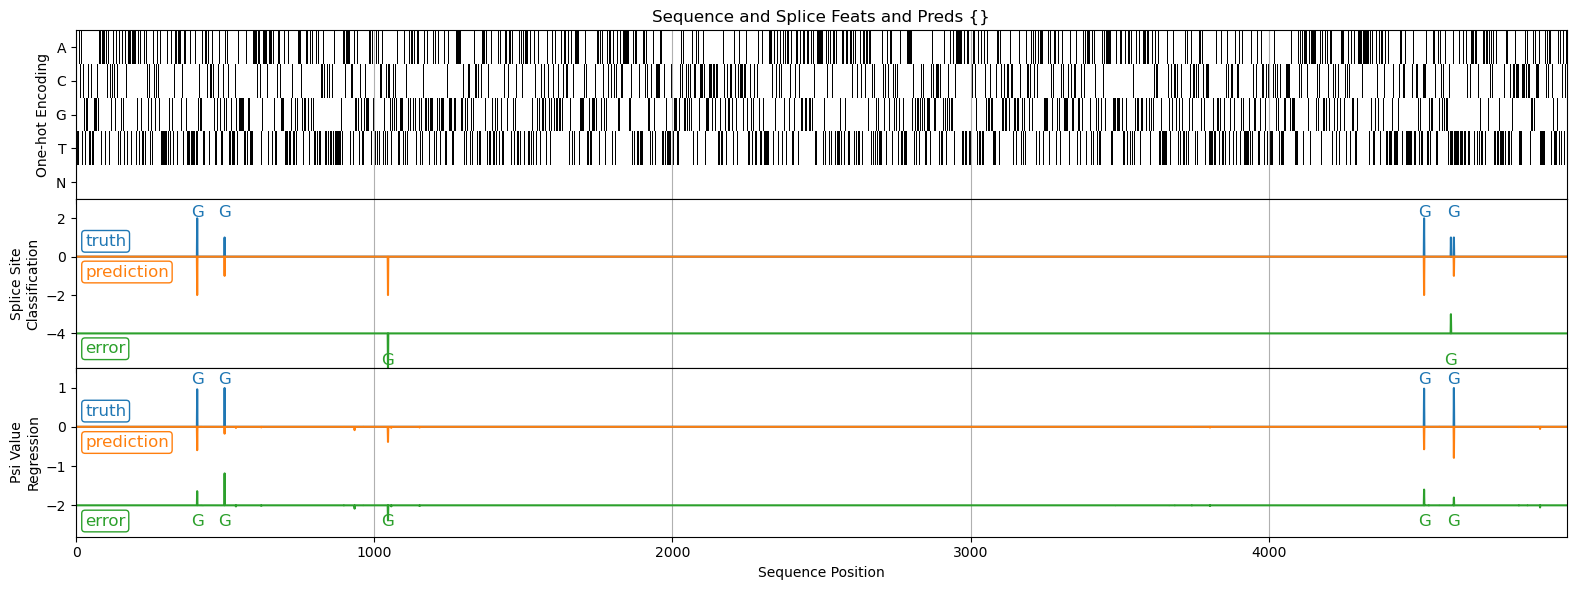

In [ ]:
batch_feats, preds = pred_outputs[0]

import matplotlib.pyplot as plt

def feats_to_device(batch_feats, device, to_numpy=True):
    """ Move a batch of features to a specified device.
    Args:
        batch_feats: dict of batched features
        device: target device
    Returns:
        batch_feats: dict of features on the target device
    """
    new_feats = {}
    for k, v in batch_feats.items():
        if isinstance(v, torch.Tensor):
            new_feats[k] = v.to(device)
            if to_numpy:
                new_feats[k] = new_feats[k].numpy()
        elif not isinstance(v, torch.Tensor):
            new_feats[k] = v
    return new_feats

def plot_feats_and_preds(feats, preds, meta_dict={}):

    fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(16, 6))
    for ax in axes:
        ax.margins(y=0)
    # panel 1: onehot encoding of sequence
    seq_onehot = feats['seq_onehot'][:, 5000:10000]
    seq_onehot = np.concatenate([seq_onehot, 1 - seq_onehot.sum(axis=0, keepdims=True)], axis=0)
    axes[0].imshow(seq_onehot, aspect='auto', cmap='Greys', interpolation='nearest')
    axes[0].set_title(f'Sequence and Splice Feats and Preds {meta_dict}')
    axes[0].set_yticks([0, 1, 2, 3, 4])
    axes[0].set_yticklabels(['A', 'C', 'G', 'T', 'N'])
    axes[0].set_ylabel('One-hot Encoding')

    # panel 2: cls
    cls_label = feats['cls']
    cls_pred = preds['cls'].argmax(axis=0)
    cls_error = cls_label - cls_pred
    axlines = axes[1].plot(cls_label, label='true')
    axlines.extend(axes[1].plot(-cls_pred, label='pred'))
    axlines.extend(axes[1].plot(cls_error - 4, label='error'))

    seq = feats['seq'][5000:10000]
    correct_pos = np.where(np.logical_and(cls_error == 0, cls_label > 0))[0]
    for p in correct_pos:
        axes[1].text(p, 2.3, seq[p], fontsize=12, color=axlines[0].get_color(), ha='center', va='center')

    axes[1].text(30, 0.8, 'truth', fontsize=12, color=axlines[0].get_color(), ha='left', va='center'
                 , bbox=dict(facecolor='none', edgecolor=axlines[0].get_color(), boxstyle='round,pad=0.2'))
    axes[1].text(30, -0.8, 'prediction', fontsize=12, color=axlines[1].get_color(), ha='left', va='center'
                 , bbox=dict(facecolor='none', edgecolor=axlines[1].get_color(), boxstyle='round,pad=0.2'))
    axes[1].text(30, -4.8, 'error', fontsize=12, color=axlines[2].get_color(), ha='left', va='center'
                 , bbox=dict(facecolor='none', edgecolor=axlines[2].get_color(), boxstyle='round,pad=0.2'))                 
                 
    err_pos = np.where(np.abs(cls_error) >= 0.5)[0]
    for p in err_pos:
        axes[1].text(p, -5.4, seq[p], fontsize=12, color=axlines[2].get_color(), ha='center', va='center')
    axes[1].set_ylim(-5.8, 3)
    axes[1].set_ylabel('Splice Site\nClassification')

    # panel 3: psi
    psi_label = feats['psi']
    psi_pred = preds['psi']
    psi_error = psi_label - psi_pred
    axlines = axes[2].plot(psi_label, label='true')
    axlines.extend(axes[2].plot(-psi_pred, label='pred'))
    axlines.extend(axes[2].plot(psi_error - 2, label='error'))
    axes[2].set_ylim(-2.8, 1.2)

    psi_pos = np.where(psi_label > 0.05)[0]
    for p in psi_pos:
        axes[2].text(p, 1.2, seq[p], fontsize=12, color=axlines[0].get_color(), ha='center', va='center')

    err_pos = np.where(np.abs(psi_error) >= 0.1)[0]
    for p in err_pos:
        axes[2].text(p, -2.4, seq[p], fontsize=12, color=axlines[2].get_color(), ha='center', va='center')
    axes[2].set_ylim(-2.8, 1.5)
    axes[2].text(30, 0.4, 'truth', fontsize=12, color=axlines[0].get_color(), ha='left', va='center'
                 , bbox=dict(facecolor='none', edgecolor=axlines[0].get_color(), boxstyle='round,pad=0.2'))
    axes[2].text(30, -0.4, 'prediction', fontsize=12, color=axlines[1].get_color(), ha='left', va='center'
                 , bbox=dict(facecolor='none', edgecolor=axlines[1].get_color(), boxstyle='round,pad=0.2'))
    axes[2].text(30, -2.4, 'error', fontsize=12, color=axlines[2].get_color(), ha='left', va='center'
                 , bbox=dict(facecolor='none', edgecolor=axlines[2].get_color(), boxstyle='round,pad=0.2'))       
    
    
    axes[2].set_xlabel('Sequence Position')
    axes[2].set_ylabel('Psi Value\nRegression')

    axes[0].grid(axis='x')
    axes[1].grid(axis='x')
    axes[2].grid(axis='x')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.show()


for i in range(len(batch_feats['cls'])):
    i = np.random.randint(len(batch_feats['cls']))
    cls_label = batch_feats['cls'][i].cpu().numpy()
    psi_label = batch_feats['psi'][i].cpu().numpy()
    if cls_label.sum() == 0 or psi_label.sum() <= 0.1:
        continue
    sample_feats = {k: v[i] for k, v in feats_to_device(batch_feats, device='cpu').items()}
    sample_preds = {k: v[i] for k, v in feats_to_device(preds, device='cpu').items()}
    plot_feats_and_preds(sample_feats, sample_preds)
    break
